<a href="https://colab.research.google.com/github/vinayasheni/deeplearning/blob/master/Mist_step2_1_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import drive


%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano
drive.mount('/content/drive', force_remount=True)
K.clear_session()

np.random.seed(237)
train_orig = pd.read_csv('/content/drive/My Drive/input/train.csv')
test_orig = pd.read_csv('/content/drive/My Drive/input/test.csv')

# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]
combined = pd.concat([train_orig, test_orig], ignore_index = True)



Mounted at /content/drive


In [0]:
# Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
del train_orig, test_orig, combined

#valid.head()

In [0]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)
#X_train[13]

In [0]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [0]:
  # Isolate original training set records in validation set
  #take 100 images
  valid_noTest = valid[valid['label'] != 11]

  valid_noTest=valid_noTest.sample(n = 100, random_state = 55)
  # X's and Y's
  X_valid_noTest = valid_noTest.drop('label', axis=1)
  y_valid_noTest = valid_noTest['label']

  # Reshape and normalize
  X_valid_noTest = X_valid_noTest.astype('float32') / 255.
  X_valid_noTest = X_valid_noTest.values.reshape(-1,28,28,1)
  

In [0]:
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [0]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
P=[1,2,4,5,6,8,10]
ssmi_mean=[0,0,0,0,0,0,0]
index=0
for latent_dim in P:
  #latent_dim = 4  # Number of latent dimension parameters

  # Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
  input_img = keras.Input(shape=img_shape)

  x = layers.Conv2D(32, 3,
                    padding='same', 
                    activation='relu')(input_img)
  x = layers.Conv2D(64, 3,
                    padding='same', 
                    activation='relu',
                    strides=(2, 2))(x)
  x = layers.Conv2D(64, 3,
                    padding='same', 
                    activation='relu')(x)
  x = layers.Conv2D(64, 3,
                    padding='same', 
                    activation='relu')(x)
  # need to know the shape of the network here for the decoder
  shape_before_flattening = K.int_shape(x)

  x = layers.Flatten()(x)
  x = layers.Dense(32, activation='relu')(x)

  # Two outputs, latent mean and (log)variance
  z_mu = layers.Dense(latent_dim)(x)
  z_log_sigma = layers.Dense(latent_dim)(x)
  # sample vector from the latent distribution
  z = layers.Lambda(sampling)([z_mu, z_log_sigma])
  # decoder takes the latent distribution sample as input
  decoder_input = layers.Input(K.int_shape(z)[1:])

  # Expand to 784 total pixels
  x = layers.Dense(np.prod(shape_before_flattening[1:]),
                  activation='relu')(decoder_input)

  # reshape
  x = layers.Reshape(shape_before_flattening[1:])(x)

  # use Conv2DTranspose to reverse the conv layers from the encoder
  x = layers.Conv2DTranspose(32, 3,
                            padding='same', 
                            activation='relu',
                            strides=(2, 2))(x)
  x = layers.Conv2D(1, 3,
                    padding='same', 
                    activation='sigmoid')(x)

  # decoder model statement
  decoder = Model(decoder_input, x)

  # apply the decoder to the sample from the latent distribution
  z_decoded = decoder(z)
  y = CustomVariationalLayer()([input_img, z_decoded])
  vae = Model(input_img, y)
  vae.compile(optimizer='rmsprop', loss=None)
  vae.fit(x=X_train, y=None,
          shuffle=True,
          epochs=7,
          batch_size=batch_size,
          validation_data=(X_valid, None))

#Take 20 images and plot them
  encoder = Model(input_img, z_mu)
  x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
  digit_decoded=decoder.predict(x_valid_noTest_encoded, batch_size=batch_size)
  for i in range(20):
     digit = digit_decoded[i].reshape(digit_size, digit_size)
     figure[index * digit_size: (index + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit
  index=index+1
  

Train on 65000 samples, validate on 5000 samples
Epoch 1/7
65000/65000 [==============================] - 51s 779us/step - loss: 0.2346 - val_loss: 0.2278
Epoch 2/7
65000/65000 [==============================] - 49s 761us/step - loss: 0.2222 - val_loss: 0.2213
Epoch 3/7
65000/65000 [==============================] - 49s 760us/step - loss: 0.2183 - val_loss: 0.2169
Epoch 4/7
65000/65000 [==============================] - 49s 760us/step - loss: 0.2164 - val_loss: 0.2185
Epoch 5/7
65000/65000 [==============================] - 50s 763us/step - loss: 0.2156 - val_loss: 0.2189
Epoch 6/7
65000/65000 [==============================] - 50s 766us/step - loss: 0.2142 - val_loss: 0.2133
Epoch 7/7
65000/65000 [==============================] - 49s 759us/step - loss: 0.2132 - val_loss: 0.2128
Train on 65000 samples, validate on 5000 samples
Epoch 1/7
65000/65000 [==============================] - 49s 756us/step - loss: 0.2091 - val_loss: 0.1982
Epoch 2/7
65000/65000 [==============================]

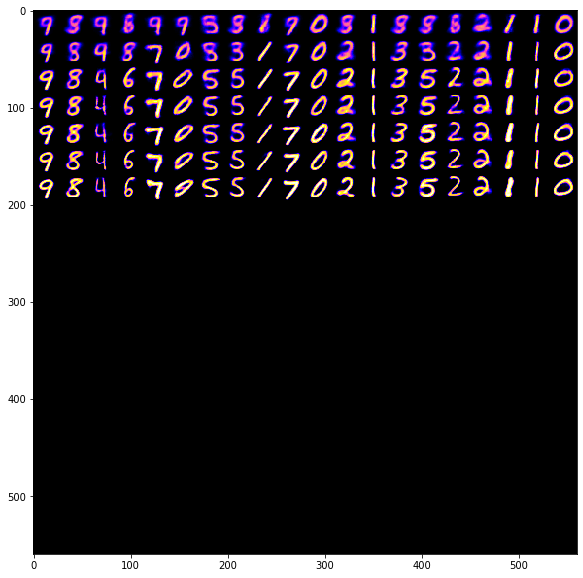

In [0]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show() 